In [43]:
import os

MODEL_SAVE_DIR = os.path.join('.','model_states')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys, os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

# Tensorflow 2.0/Keras imports
import tensorflow as tf
print(f"Using Tensorflow {tf.__version__}")
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='whitegrid', context='notebook', font_scale=1.2)
# log only errors from Tensorflow
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# reduce Tensorflow warnings overload
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using Tensorflow 2.4.1


## Building Keras Models using various APIs

In [3]:
# using Sequential API
seq_model = Sequential([
    Dense(256, input_shape=(28*28*1,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
])
print(seq_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
# using Functional API
def build_model():
    inp = Input(shape=(28*28*1,))
    d1 = Dense(256, activation='relu')(inp)
    d2 = Dense(128, activation='relu')(d1)
    out = Dense(10, activation='sigmoid')(d2)
    return Model(inputs=inp, outputs=out)

fxn_model = build_model()
print(fxn_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
# using new Class API
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Dense(256, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.out = Dense(10, activation='softmax')
        
    def call(self, inputs, **kwargs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out(x)
    
cls_model = MyModel()

In [6]:
# loading & preprocessing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"After loading -> X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - " +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}")

X_train = X_train.reshape((-1, 28*28*1))
X_test = X_test.reshape((-1, 28*28*1))

X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

# one-hot-encode the labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

print(f"After preprocessing -> X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - " +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}")

After loading -> X_train.shape: (60000, 28, 28) - y_train.shape: (60000,) - X_test.shape: (10000, 28, 28) - y_test.shape: (10000,)
After preprocessing -> X_train.shape: (60000, 784) - y_train.shape: (60000, 10) - X_test.shape: (10000, 784) - y_test.shape: (10000, 10)


In [7]:
# split X_train/y_train into train/cross-val sets
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.20, random_state=SEED)
print(f"After preprocessing & splitting -> X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - " +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - " +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}")

After preprocessing & splitting -> X_train.shape: (8000, 784) - y_train.shape: (8000, 10) - X_val.shape: (2000, 784) - y_val.shape: (2000, 10) - X_test.shape: (10000, 784) - y_test.shape: (10000, 10)


In [8]:
# compile all the models
models = { 'Sequential' : seq_model, 'Functional' : fxn_model, 'Class' : cls_model }
for model_name, model in models.items():
    print(f'Compiling {model_name} model')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # train the model
    print(f"Training {model_name} model...", flush=True)
    model.fit(X_train, y_train, epochs=50, batch_size=256, verbose=0)
    
    print(f"Evaluating {model_name} model...")
    loss, acc = model.evaluate(X_train, y_train, verbose=0)
    print(f"  Training  -> loss: {loss:.3f} - {acc:.3f}")
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"  Cross-val -> loss: {loss:.3f} - {acc:.3f}")
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"  Test      -> loss: {loss:.3f} - {acc:.3f}")
    print("\n")

Compiling Sequential model
Training Sequential model...
Evaluating Sequential model...
  Training  -> loss: 0.000 - 1.000
  Cross-val -> loss: 0.229 - 0.959
  Test      -> loss: 0.046 - 0.992


Compiling Functional model
Training Functional model...
Evaluating Functional model...
  Training  -> loss: 0.000 - 1.000
  Cross-val -> loss: 0.222 - 0.961
  Test      -> loss: 0.045 - 0.992


Compiling Class model
Training Class model...
Evaluating Class model...
  Training  -> loss: 0.000 - 1.000
  Cross-val -> loss: 0.218 - 0.960
  Test      -> loss: 0.044 - 0.992




## Multiclass Classification on Images Data

### Loading Images using Keras API

In [9]:
import glob, tarfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file

In [10]:
DATASET_URL = 'https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz?sequence=4&isAllowed=y'
DATA_NAME = 'cinic10'
FILE_EXTENSION = 'tar.gz'
FILE_NAME = '.'.join([DATA_NAME, FILE_EXTENSION])
print(f"{FILE_NAME}")

cinic10.tar.gz


In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# this is needed to resolve error: URL fetch failure on https://.... None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: 
# unable to get local issuer certificate (_ssl.c:1123)

In [12]:
downloaded_file_loc = "/home/mjbhobe/.keras/datasets/cinic10.tar.gz"
if not os.path.exists(downloaded_file_loc):
    downloaded_file_loc = get_file(origin=DATASET_URL, fname=FILE_NAME, extract=False)
    print(f"Downloaded to {downloaded_file_loc}")

In [13]:
data_directory, _ = downloaded_file_loc.rsplit(os.path.sep, maxsplit=1)
data_directory = os.path.sep.join([data_directory, DATA_NAME])

if not os.path.exists(data_directory):
    print(f"Will extract images to {data_directory}")
    tar = tarfile.open(downloaded_file_loc)
    tar.extractall(data_directory)
else:
    print('Images have already been downloaded & extracted')

Images have already been downloaded & extracted


In [14]:
data_pattern = os.path.sep.join([data_directory, "*/*/*.png"])
images_paths =  list(glob.glob(data_pattern))
print(f"Found {len(images_paths):,} images in dataset")

Found 270,000 images in dataset


/home/mjbhobe/.keras/datasets/cinic10/train/cat/n02123394_7750.png


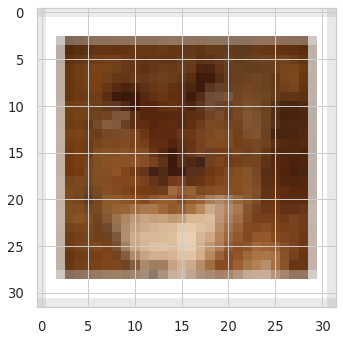

In [15]:
rand_index = np.random.choice(np.arange(len(images_paths)),1)[0]
sample_image = images_paths[rand_index]
print(sample_image)
plt.imshow(img_to_array(load_img(sample_image))/255.0);

Found 270000 images belonging to 3 classes.


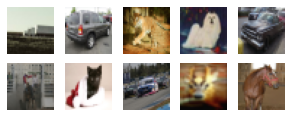

In [16]:
image_generator = ImageDataGenerator(horizontal_flip=True, rescale=1.0/255.0)
iterator = image_generator.flow_from_directory(data_directory, batch_size=10)
for batch, _ in iterator:
    plt.figure(figsize=(5,5))
    for index, image in enumerate(batch, start=1):
        ax = plt.subplot(5, 5, index)
        plt.imshow(image)
        plt.axis("off")
    plt.show()
    break

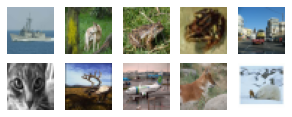

In [17]:
# and he is how we do the same using tf.data.dataset API
image_dataset = tf.data.Dataset.list_files(data_pattern)

plt.figure(figsize=(5,5))
for index, image_path in enumerate(image_dataset.take(10), start=1):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, np.float32)
    ax = plt.subplot(5, 5, index)
    plt.imshow(image)
    plt.axis('off')

In [72]:
train_images_dir = os.path.join(data_directory, 'train')
cval_images_dir = os.path.join(data_directory, 'valid')
test_images_dir = os.path.join(data_directory, 'test')
print(f"train images dir: {train_images_dir} - cross-val images dir: {cval_images_dir} - test images dir: {test_images_dir}")

train images dir: /home/mjbhobe/.keras/datasets/cinic10/train - cross-val images dir: /home/mjbhobe/.keras/datasets/cinic10/valid - test images dir: /home/mjbhobe/.keras/datasets/cinic10/test


In [73]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

cval_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [74]:
train_generator = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(32,32),
    batch_size=64)

cval_generator = cval_datagen.flow_from_directory(
    cval_images_dir,
    target_size=(32,32),
    batch_size=64)

test_generator = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(32,32),
    batch_size=64)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [75]:
# build the model
from tensorflow.keras import Model
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dense, Dropout, Flatten, Input,
                                     LeakyReLU, MaxPooling2D, Softmax)
from tensorflow.keras.utils import plot_model
import kr_helper_funcs as kru

In [78]:
def build_model():
    inp = Input(shape=(32,32,3), name='input')
    
    x = Conv2D(filters=32, kernel_size=(2,2), padding='same', strides=(2,2), name='Conv2D_1')(inp)
    x = LeakyReLU(name='actvation_1')(x)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same', name='max_pool_1')(x)
    
    x = Conv2D(filters=32, kernel_size=(2,2), padding='same', strides=(2,2), name='Conv2D_2')(x)
    x = LeakyReLU(name='actvation_2')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same', name='max_pool_2')(x)
    
    x = Conv2D(filters=64, kernel_size=(2,2), padding='same', strides=(2,2), name='Conv2D_3')(x)
    x = LeakyReLU(name='actvation_3')(x)
    x = BatchNormalization(name='batch_norm_3')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same', name='max_pool_3')(x)
    x = Dropout(rate=0.5, name='dropout_3')(x)
    
    flatten = Flatten(name='flatten')(x)
    
    x = Dense(units=256, name='dense_1')(flatten)
    x = LeakyReLU(name='actvation_d1')(x)

    x = Dense(units=128, name='dense_2')(x)
    x = LeakyReLU(name='actvation_d2')(x)

    x = Dense(units=10, name='dense_3')(x)
    out = Softmax(name='actvation_d3')(x)
    
    model = Model(inputs=inp, outputs=out)
    return model

In [79]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 16, 16, 32)        416       
_________________________________________________________________
actvation_1 (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 8, 8, 32)          4128      
_________________________________________________________________
actvation_2 (LeakyReLU)      (None, 8, 8, 32)          0   

In [80]:
history = model.fit(
    train_generator,
    steps_per_epoch=250,
    epochs=75,
    validation_data=cval_generator,
    validation_steps=50, 
    workers=3
)

Epoch 1/75
250/250 [==============================] - 155s 610ms/step - loss: 2.2902 - accuracy: 0.2363 - val_loss: 2.6493 - val_accuracy: 0.1469
Epoch 2/75
250/250 [==============================] - 133s 526ms/step - loss: 1.8263 - accuracy: 0.3228 - val_loss: 1.7195 - val_accuracy: 0.3716
Epoch 3/75
250/250 [==============================] - 127s 502ms/step - loss: 1.7727 - accuracy: 0.3437 - val_loss: 1.8962 - val_accuracy: 0.3313
Epoch 4/75
250/250 [==============================] - 105s 418ms/step - loss: 1.7363 - accuracy: 0.3641 - val_loss: 1.6718 - val_accuracy: 0.3991
Epoch 5/75
250/250 [==============================] - 89s 354ms/step - loss: 1.7011 - accuracy: 0.3715 - val_loss: 1.5997 - val_accuracy: 0.4069
Epoch 6/75
250/250 [==============================] - 85s 336ms/step - loss: 1.6556 - accuracy: 0.3909 - val_loss: 1.5709 - val_accuracy: 0.4244
Epoch 7/75
250/250 [==============================] - 79s 311ms/step - loss: 1.6679 - accuracy: 0.3860 - val_loss: 1.5721 - va

250/250 [==============================] - 74s 295ms/step - loss: 1.4019 - accuracy: 0.4872 - val_loss: 1.3227 - val_accuracy: 0.5097
Epoch 58/75
250/250 [==============================] - 75s 298ms/step - loss: 1.3847 - accuracy: 0.4917 - val_loss: 1.4194 - val_accuracy: 0.4781
Epoch 59/75
250/250 [==============================] - 70s 278ms/step - loss: 1.3966 - accuracy: 0.4814 - val_loss: 1.6278 - val_accuracy: 0.4244
Epoch 60/75
250/250 [==============================] - 67s 267ms/step - loss: 1.3867 - accuracy: 0.4882 - val_loss: 1.3395 - val_accuracy: 0.5103
Epoch 61/75
250/250 [==============================] - 89s 350ms/step - loss: 1.3809 - accuracy: 0.4962 - val_loss: 1.3668 - val_accuracy: 0.4944
Epoch 62/75
250/250 [==============================] - 110s 439ms/step - loss: 1.3914 - accuracy: 0.4939 - val_loss: 1.4126 - val_accuracy: 0.4825
Epoch 63/75
250/250 [==============================] - 104s 413ms/step - loss: 1.3781 - accuracy: 0.4936 - val_loss: 1.4042 - val_accur

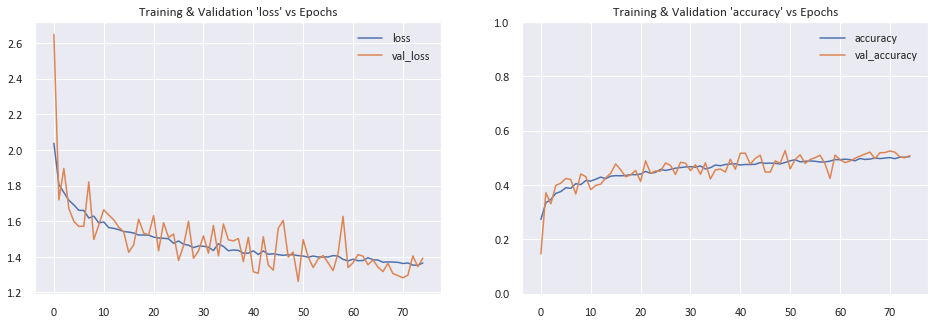

In [81]:
#plot_model_history(history, 'loss', [0., 2.5])
kru.show_plots(history.history, metric='accuracy')

In [82]:
loss, acc = model.evaluate(train_generator, batch_size=64)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate(cval_generator, batch_size=64)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate(test_generator, batch_size=64)
print('Test data      -> loss: %.3f, acc: %.3f' % (loss, acc))

1407/1407 [==============================] - 766s 544ms/step - loss: 1.4281 - accuracy: 0.4720
Training data  -> loss: 1.428, acc: 0.472
1407/1407 [==============================] - 1038s 738ms/step - loss: 1.4027 - accuracy: 0.4959
Cross-val data -> loss: 1.403, acc: 0.496
1407/1407 [==============================] - 1027s 730ms/step - loss: 1.4108 - accuracy: 0.4943
Test data      -> loss: 1.411, acc: 0.494


In [83]:
kru.save_model(model, "kr_cinic10", MODEL_SAVE_DIR)
del model

Saved model to file ./model_states/kr_cinic10.h5


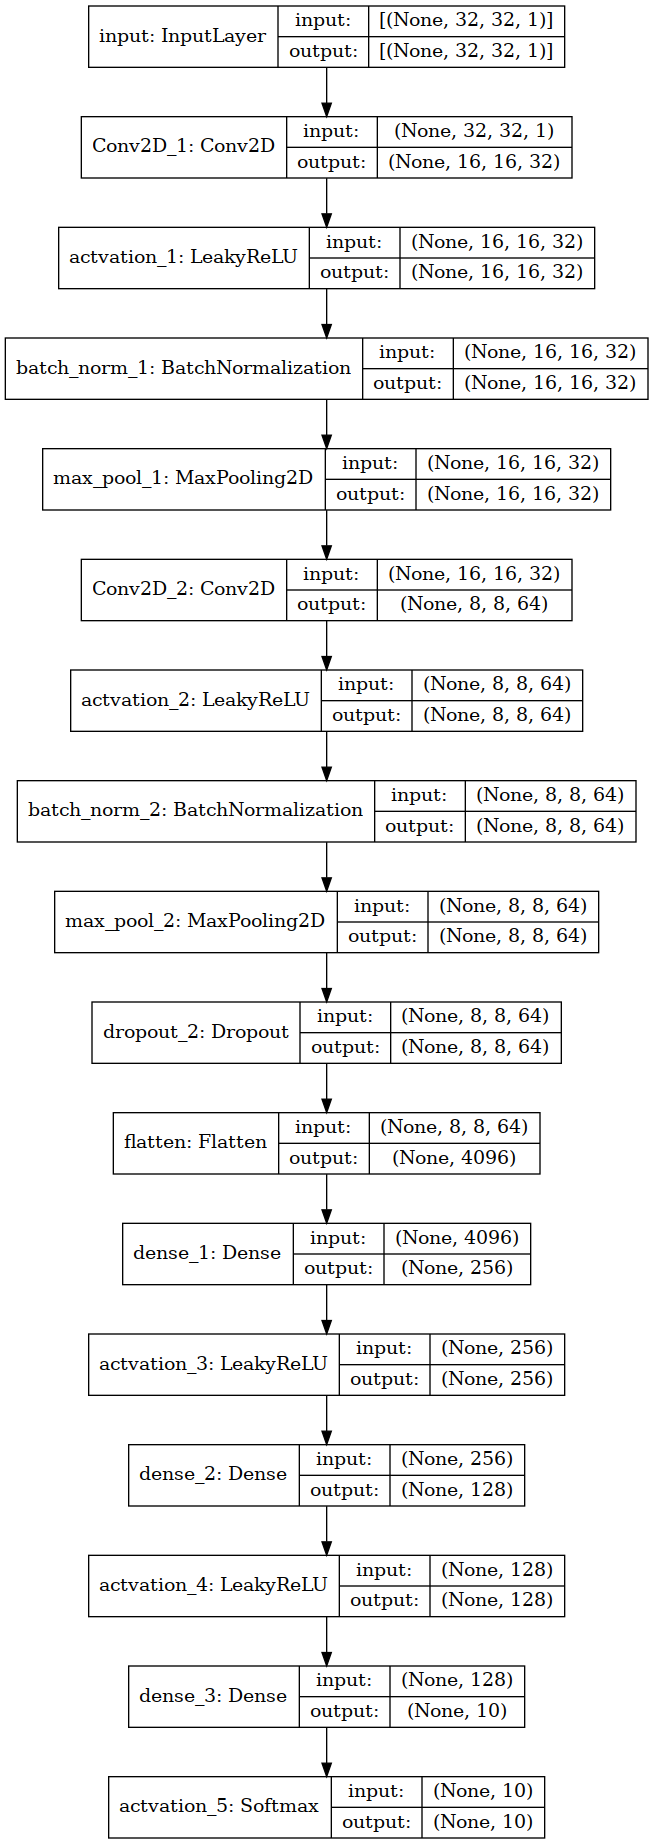

In [23]:
plot_model(model, show_shapes=True, show_layer_names=True)